In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

**Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [3]:
#"D:\AI\Machine learning\my_PJME_MW.csv"
Path_Energy = 'D:/AI/Machine learning/my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [4]:
data_w = data.resample('W').mean()
data_w.tail(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.0,0.0,0.0
2018-07-29,36581.821429,2018.0,7.000000,26.000000,3.0,207.000000,30.0,3.000000,11.500000,0.0,0.0,0.0
2018-08-05,36568.804124,2018.0,7.505155,15.865979,3.0,212.525773,31.0,1.525773,11.381443,0.0,0.0,0.0


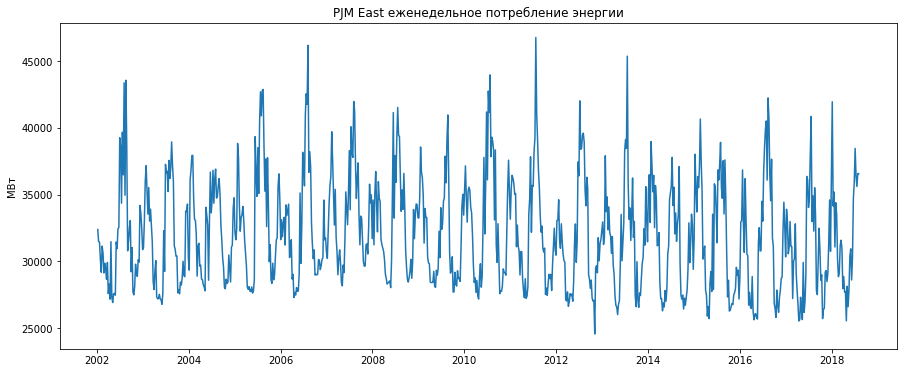

In [5]:
plt.figure(figsize =(15, 6))
plt.plot( data_w.index, data_w['PJME_MW'].values)
plt.title('PJM East еженедельное потребление энергии')
plt.ylabel ('МВт');

In [6]:
p = [2, 4, 6, 8]
d = range(1, 3)
q = range(2, 4)

In [7]:
# зададим сетку p, d и q
pdq = list(itertools.product(p, d, q))
pdq

[(2, 1, 2),
 (2, 1, 3),
 (2, 2, 2),
 (2, 2, 3),
 (4, 1, 2),
 (4, 1, 3),
 (4, 2, 2),
 (4, 2, 3),
 (6, 1, 2),
 (6, 1, 3),
 (6, 2, 2),
 (6, 2, 3),
 (8, 1, 2),
 (8, 1, 3),
 (8, 2, 2),
 (8, 2, 3)]

Параметры модели:   
    p = 8   
    d = 2   
    q = 3

In [8]:
data_w['exp_0_5'] = exponential_smoothing(data_w['PJME_MW'], 0.5)

Добавим истории длиной p в признаках автокорреляции

In [9]:
p = 8
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

первые разности

In [10]:
p = 8
first_diff = data_w.iloc[1:, 0].values - data_w.iloc[:-1, 0].values 
data_w['diff1'] = 0
data_w['diff1'].values[1:] = first_diff

for i in range(p):
    data_w['d'+str(p-i)] = 0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

In [11]:
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,...,t1,diff1,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,...,0,-904,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,...,0,-34,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,...,0,-1311,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,...,0,-945,0,0,0,0,0,0,0,0


In [12]:
data_w.columns

Index(['PJME_MW', 'year', 'month', 'dayofmonth', 'quarter', 'dayofyear',
       'weekofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'exp_0_5', 't8', 't7', 't6', 't5', 't4', 't3', 't2',
       't1', 'diff1', 'd8', 'd7', 'd6', 'd5', 'd4', 'd3', 'd2', 'd1'],
      dtype='object')

In [13]:
data_w = data_w[['PJME_MW', 'dayofyear',
       'weekofyear', 'is_holiday', 'is_prev_holiday',
       'is_next_holiday', 'exp_0_5', 't8', 't7', 't6', 't5', 't4', 't3', 't2',
       't1', 'd7', 'diff1', 'd8', 'd7', 'd6', 'd5', 'd4', 'd3', 'd2', 'd1']]

In [14]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [15]:
train, test = split_data(data_w, '2016-01-01')

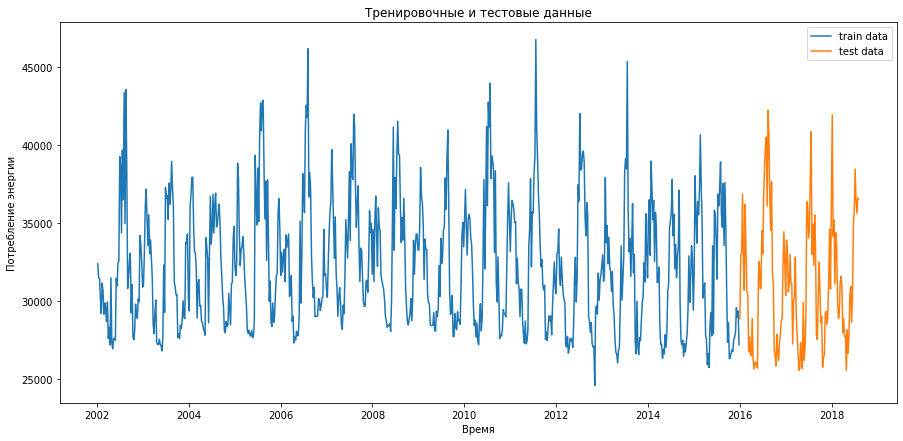

In [16]:
plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'), train[data_w.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[data_w.columns[0]], label='test data')
plt.title('Тренировочные и тестовые данные')
plt.legend();

**Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .**

In [17]:
h = 4

In [18]:
X_train_4 = train.iloc[:-h,:]

In [19]:
y_train_4 = train[data_w.columns[0]].values[:-h]

In [20]:
X_test_4 = test.iloc[:-h,:]

In [21]:
y_test_4 = test[data_w.columns[0]].values[:-h]

In [22]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

model_gb.fit(X_train_4, y_train_4) 
X_test_pred_gb_4 = model_gb.predict(X_test_4)

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

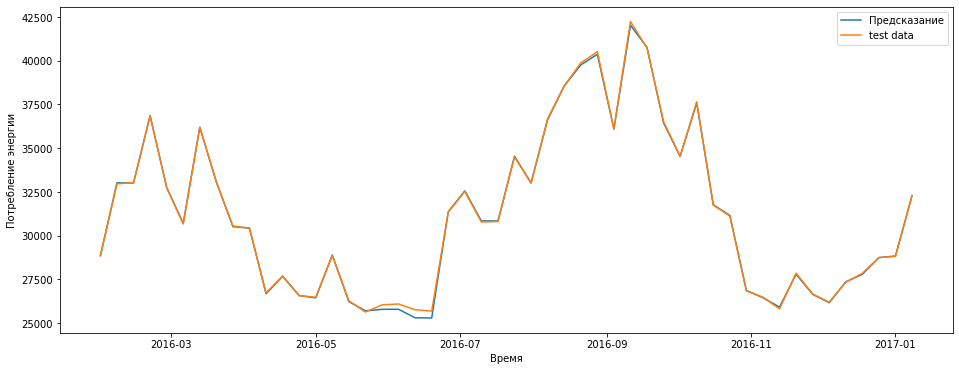

ошибка градиентного бустинга :   0.17800661834772522 %


In [24]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb_4[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_4 = mean_absolute_percentage_error(y_true=y_test_4, y_pred=X_test_pred_gb_4)

print('ошибка градиентного бустинга :  ', er_g_4, '%')

**Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [25]:
h = 1

In [26]:
X_train_1 = train.iloc[:-h,:]

In [27]:
y_train_1 = train[data_w.columns[0]].values[:-h]

In [28]:
X_test_1 = test.iloc[:-h,:]

In [29]:
y_test_1 = test[data_w.columns[0]].values[:-h]

In [30]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb_1 = model_gb.predict(X_test_1)

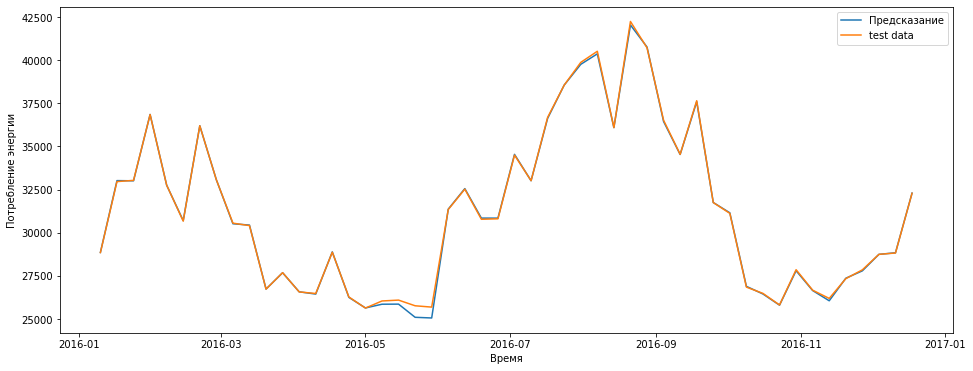

ошибка градиентного бустинга :   0.1812344851148806 %


In [31]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb_1[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb_1)

print('ошибка градиентного бустинга :  ', er_g_1, '%')

**Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [32]:
columns = len(data_w.columns)
columns

25